# Data preprocessing pipeline

This notebook explain our preprocess operations to generate the processed dataset.

We agree on the following `X`s and `y`: 

* X : `account`, `sector`, `revenue`, `office_location`, `sales_agent`, `product`, `deal_stage`, `duration`
* y: `close_value`

In [85]:
!cd ../ && make data_extract


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  142k  100  142k    0     0   147k      0 --:--:-- --:--:-- --:--:--  147k
Archive:  data/raw/crm-sales-opportunities.zip


In [ ]:
import pandas as pd

DATA_PATH = "../data/raw/"

df_accounts = pd.read_csv(DATA_PATH + "accounts.csv")
df_products = pd.read_csv(DATA_PATH + "products.csv")
df_teams = pd.read_csv(DATA_PATH + "sales_teams.csv")
df_sales = pd.read_csv(DATA_PATH + "sales_pipeline.csv")

df = df_sales.copy()
df.sample(10)


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
1685,ZW7N89K3,Rosalina Dieter,GTXPro,Faxquote,Lost,2017-03-20,2017-05-18,0.0
7632,RVUJPYY8,Rosalina Dieter,MG Special,NaN,Engaging,2017-10-18,NaN,NaN
7220,MYD4PBM9,Kary Hendrixson,GTX Basic,NaN,Engaging,2017-10-03,NaN,NaN
4686,0T9KUEQ2,Cassey Cress,GTX Plus Pro,NaN,Engaging,2017-07-11,NaN,NaN
3198,SFCT64YG,Niesha Huffines,GTX Basic,Inity,Won,2017-05-15,2017-09-05,545.0
8777,WAT7H38N,Versie Hillebrand,MG Special,NaN,Prospecting,NaN,NaN,NaN
4061,2FGEGLVU,Vicki Laflamme,MG Special,Doncon,Lost,2017-06-20,2017-06-23,0.0
3238,3SEMPUU1,Markita Hansen,GTXPro,Labdrill,Engaging,2017-05-17,NaN,NaN
882,N6H58J55,Anna Snelling,GTX Basic,Streethex,Lost,2017-02-15,2017-05-13,0.0
4544,DOVNGYN4,Kami Bicknell,GTX Basic,Green-Plus,Lost,2017-07-06,2017-07-12,0.0


In [ ]:
# Remove rows without a `y` (i.e. `close_value` is NaN):
df.dropna(subset=['close_value'], inplace=True)
total_sales = df_sales.shape[0]
actual_sales = df.shape[0]
print(f"{total_sales} sales in total")
print(f"{actual_sales} actual sales")
print(f"{total_sales - actual_sales} still prospecting")


8800 sales in total
6711 actual sales
2089 still prospecting


In [ ]:
# Transform sales status into a binary column (`Won` = 1, otherwise 0)
def deal_stage_binary(value):
    return int(1 if value.lower() == 'won' else 0)


df['won'] = df['deal_stage'].apply(deal_stage_binary)
df['won'] = pd.to_numeric(df['won'], downcast='integer')
df['won'].value_counts()


won
1    4238
0    2473
Name: count, dtype: int64

<Axes: xlabel='Duration (in days)', ylabel='Count of sales'>

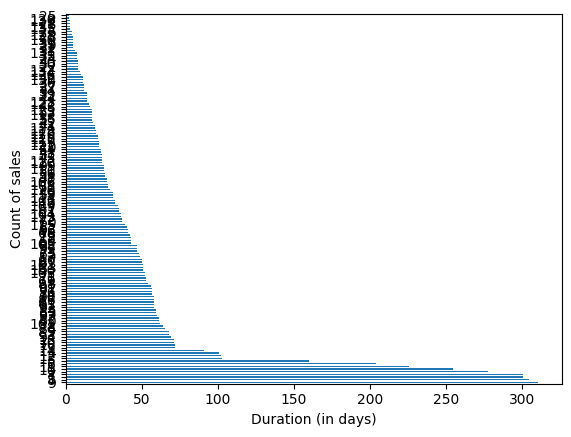

In [ ]:
# Get the duration
df['engage_date'] = pd.to_datetime(df['engage_date'])
df['close_date'] = pd.to_datetime(df['close_date'])
df['duration'] = (df['close_date'] - df['engage_date']).dt.days
df['duration'] = pd.to_numeric(df['duration'], downcast='integer')
df['duration'].value_counts().plot(
    kind="barh", xlabel='Duration (in days)', ylabel="Count of sales")


In [ ]:
# Merge information about Sale agent.
columns = ['sales_agent', 'manager', 'regional_office']
if 'manager' not in df.columns:
    df = pd.merge(
        df, df_teams[columns], on='sales_agent', how='left')

df['regional_office'].value_counts()


regional_office
Central    2604
West       2249
East       1858
Name: count, dtype: int64

In [ ]:
# Merge information about Account (i.e. clients).
columns = ['account', 'sector', 'revenue', 'office_location']
if 'sector' not in df.columns:
    df = pd.merge(
        df, df_accounts[columns], on='account', how='left')

df['sector'].value_counts()


sector
retail                1267
technolgy             1058
medical                950
software               704
marketing              623
finance                613
telecommunications     456
entertainment          402
services               352
employment             286
Name: count, dtype: int64

In [ ]:
# Merge information about Product (i.e. catalog).
columns = ['product', 'series', 'sales_price']
if 'series' not in df.columns:
    df = pd.merge(
        df, df_products[columns], on='product', how='left')

df['series'].value_counts()


series
GTX    3232
MG     2307
GTK      25
Name: count, dtype: int64

In [ ]:
# Reorder columns.
cols = list(df.columns)
cols.remove('product')
cols.remove('series')
cols.remove('sales_price')
cols.remove('duration')
cols.remove('won')
cols.remove('close_value')

cols.append('product')
cols.append('series')
cols.append('sales_price')
cols.append('duration')
cols.append('won')
cols.append('close_value')
df = df[cols]


In [ ]:
# Remove useless columns.
for col in ['opportunity_id', 'engage_date', 'close_date', 'deal_stage']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)


In [ ]:
# All object columns are just text.
for col in (df.select_dtypes(include=['object'])).columns:
    df[col] = df[col].astype('string')


In [ ]:
# Our target is a number.
df['close_value'] = pd.to_numeric(df['close_value'], downcast='integer')


In [ ]:
df.dtypes


sales_agent        string[python]
account            string[python]
manager            string[python]
regional_office    string[python]
sector             string[python]
revenue                   float64
office_location    string[python]
product            string[python]
series             string[python]
sales_price               float64
duration                    int16
won                          int8
close_value                 int16
dtype: object

In [ ]:
df.to_csv('../data/processed/dataset.csv')
